In [10]:
import sys
sys.path.append('../')
import pickle
import matplotlib.pyplot as plt
from array import array
import numpy as np
import mplhep as hep
import ROOT
import tdrstyle

#set the tdr style for root plotting
tdrstyle.setTDRStyle()
ROOT.gStyle.SetPadTickX(1)  # To get tick marks on the opposite side of the frame
ROOT.gStyle.SetPadTickY(1)
ROOT.gStyle.SetLegendBorderSize(0) # Erase border of legend

In [11]:
%%cpp
TH1D fill_histo(std::vector<double> values, TString name, int n_bins, double v_min, double v_max){
    TH1D histo(name, "", n_bins, v_min, v_max);
    for (int i=0; i<values.size(); i++){
        histo.Fill(values.at(i));
    }
    return histo;
};

In [12]:
%%cpp
TH2D fill_2d_histo(std::vector<double> x_values, std::vector<double> y_values, int n_xbins, double x_min, double x_max, int n_ybins, double y_min, double y_max){
    TH2D histo("h", "", n_xbins, x_min, x_max, n_ybins, y_min, y_max);
    for (int i=0; i<x_values.size(); i++){
        histo.Fill(x_values.at(i), y_values.at(i));
    }
    return histo;
};

In [13]:
def set_hist2d_style(h2, title, title_x, title_y):
    h2.GetYaxis().SetTitle(title_y)
    h2.GetYaxis().SetLabelSize(0.05)
    h2.GetYaxis().SetTitleSize(0.05)
    h2.GetYaxis().SetTitleOffset(1.2)
    
    h2.GetXaxis().SetTitle(title_x)
    h2.GetXaxis().SetLabelSize(0.05)
    h2.GetXaxis().SetTitleSize(0.05)
    h2.GetXaxis().SetTitleOffset(1.2)
    
    return h2

In [14]:
# Get gen lxy, reco lxy and reco lxy error from result object
# Select only events with gen lxy in specified range
def get_lxy_infos(result, lxy_range):
    Lxy_gen = result["num_Lxy_gen"][ds].value
    Lxy_reco = result["num_dxy_dsapair"][ds].value
    Lxy_reco_err = result["num_dxy_dsapair_error"][ds].value
    if lxy_range[1] is None:
        selection = (Lxy_gen >= lxy_range[0])
    else:
        selection = np.logical_and(Lxy_gen >= lxy_range[0], Lxy_gen < lxy_range[1])
    Lxy_reco = Lxy_reco[selection]
    Lxy_reco_err = Lxy_reco_err[selection]
    Lxy_gen = Lxy_gen[selection]
    return Lxy_gen, Lxy_reco, Lxy_reco_err

In [4]:
result_dir = "/Users/mascella/workspace/disp_muon_studies/Results/"
tag = "230112"
with open(result_dir + f"result_{tag}.pkl", "rb") as f:
    result = pickle.load(f)
ds = "2Mu2J"

In [5]:
high_lxy = True
Lxy_gen = result["num_Lxy_gen"][ds].value
Lxy_reco = result["num_dxy_dsapair"][ds].value
Lxy_reco_err = result["num_dxy_dsapair_error"][ds].value
if high_lxy:
#     sel = np.logical_and(Lxy_gen<300, Lxy_gen>200)
    sel = Lxy_gen > 330
    Lxy_reco = Lxy_reco[sel]
    Lxy_reco_err = Lxy_reco_err[sel]
    Lxy_gen = Lxy_gen[sel]
print("len Lxy_gen:", len(Lxy_gen))
print("len Lxy_reco:", len(Lxy_reco))

len Lxy_gen: 442
len Lxy_reco: 442


Text(0, 1, 'Counts')

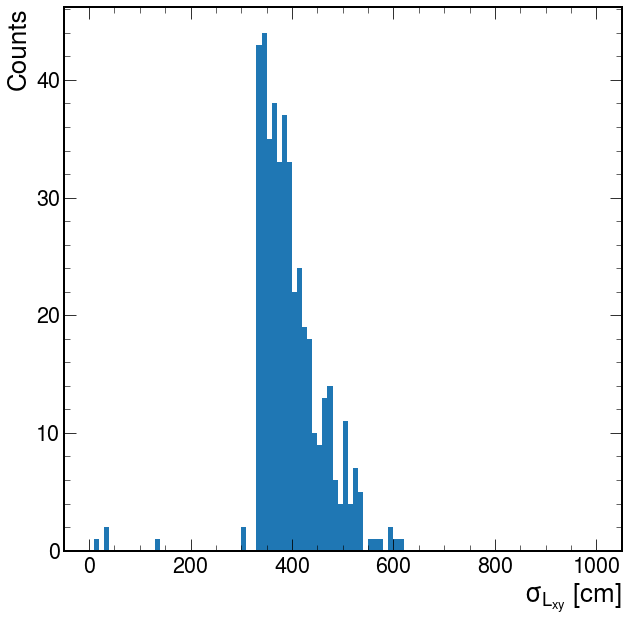

In [6]:
plt.style.use(hep.style.ROOT)
plt.hist(Lxy_reco, bins=100, range=[0,1000])
plt.xlabel(r"$\sigma_{L_{xy}}$ [cm]")
plt.ylabel("Counts")
# plt.yscale("log")

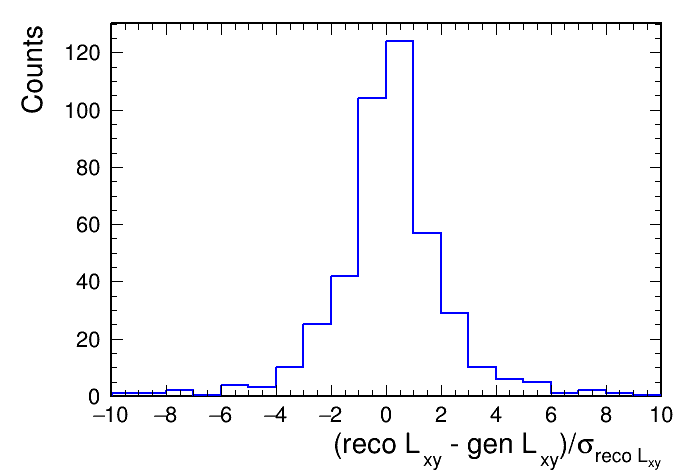

In [7]:
res = array("d", Lxy_reco - Lxy_gen)
pull = array("d", (Lxy_reco - Lxy_gen)/Lxy_reco_err)
c = ROOT.TCanvas()
hist_res = ROOT.fill_histo(pull, f"pulls_{tag}", 20, -10, 10)
hist_res.GetXaxis().SetTitle("(reco L_{xy} - gen L_{xy})/#sigma_{reco L_{xy}}")
hist_res.GetYaxis().SetTitle("Counts")
hist_res.SetLineColor(ROOT.kBlue)
# hist_res.Fit("gaus")
# ROOT.gPad.SetLogy(1)
hist_res.Draw()
c.Draw()

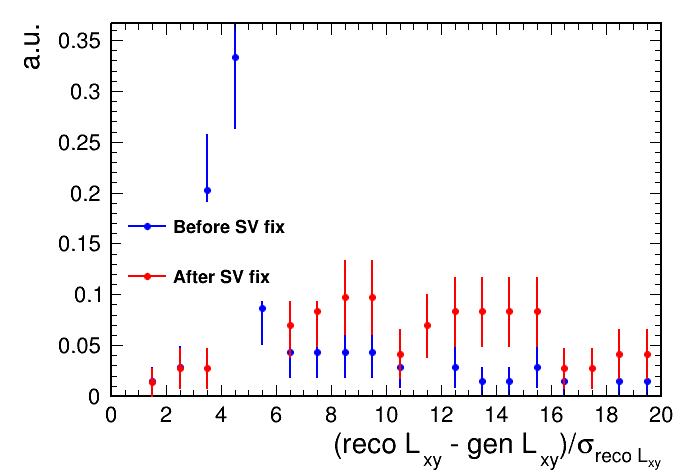

In [9]:
ds = "2Mu2J"
range_lxy = [330, None]

# Make pull plot before and after the SV fix for given dataset
c = ROOT.TCanvas("c", "", 1)
tag_dict = {'230112_noSvFix': "Before SV fix", '230112':  "After SV fix"}
colors = [ROOT.kBlue, ROOT.kRed]
histos = []
maxima = []
for i, tag in enumerate(tag_dict):
    with open(result_dir + f'result_{tag}.pkl', 'rb') as f:
        result = pickle.load(f)
    Lxy_gen, Lxy_reco, Lxy_reco_err = get_lxy_infos(result, range_lxy)
#     res = array("d", Lxy_reco - Lxy_gen)
#     pull = array("d", (Lxy_reco - Lxy_gen)/Lxy_reco_err)
    pull = array("d", Lxy_reco/Lxy_reco_err)
    hist_res = ROOT.fill_histo(pull, f"res_{tag}", 20, 0, 20)
    hist_res.GetXaxis().SetTitle("(reco L_{xy} - gen L_{xy})/#sigma_{reco L_{xy}}")
#     hist_res.GetXaxis().SetTitle("reco L_{xy} - gen L_{xy} [cm]")
    hist_res.GetYaxis().SetTitle("a.u.")
    hist_res.SetLineColor(colors[i])
    hist_res.SetMarkerColor(colors[i])
    hist_res.SetTitle(tag_dict[tag])
    n_ev = hist_res.Integral()
    hist_res.Scale(1./n_ev)  
    maxima.append(hist_res.GetMaximum())
    histos.append(hist_res)
    
n=0
for hist in histos:
    hist.GetYaxis().SetRangeUser(0, 1.1* max(maxima))
    if n == 0:
        hist.Draw("")
    else:
        hist.Draw("same")
    c.Update()
    n += 1
legend = c.BuildLegend()
# legend.Draw("NB")
c.Draw()

In [30]:
result_dir = "/Users/mascella/workspace/disp_muon_studies/Results/"
tag = "230112"
with open(result_dir + f'result_{tag}.pkl', 'rb') as f:
        result = pickle.load(f)
ds = "2Mu2J"
do_fit = False
# range_dict = {"200 < gen L_{xy} < 300 cm": [200, 300], "gen L_{xy} > 330 cm": [330, None]}
range_dict = {"200 < gen L_{xy} < 300 cm": [200, 300]}

variables = {"pull": ["(reco L_{xy} - gen L_{xy})/#sigma_{reco L_{xy}}", [-10, 10]], 
             "Lxy_significance": ["reco L_{xy}/#sigma_{reco L_{xy}}", [0, 20]]}
var = "pull"
label = variables[var][0]
range_var = variables[var][1]

# Make pull plot for the low and high gen lxy ranges, for given tag and dataset
c = ROOT.TCanvas("c2", "", 1)
colors = [ROOT.kGreen + 2, ROOT.kMagenta]
histos = []
maxima = []

for i, range_lxy_label in enumerate(range_dict):
    Lxy_gen, Lxy_reco, Lxy_reco_err = get_lxy_infos(result, range_dict[range_lxy_label])
    if var=="pull":
        hist_array = array("d", (Lxy_reco - Lxy_gen)/Lxy_reco_err)
    elif var=="Lxy_significance":
        hist_array = array("d", Lxy_reco/Lxy_reco_err)
    else:
        hist_array = array("d", Lxy_reco/Lxy_reco_err)
    hist_res = ROOT.fill_histo(hist_array, f"{var}_{range_lxy_label}", 20, range_var[0], range_var[1])
    hist_res.GetXaxis().SetTitle(label)
    hist_res.GetYaxis().SetTitle("a.u.")
    hist_res.SetLineColor(colors[i])
    hist_res.SetMarkerColor(colors[i])
    hist_res.SetTitle(range_lxy_label)
    n_ev = hist_res.Integral()
    hist_res.Scale(1./n_ev)  
    maxima.append(hist_res.GetMaximum())
    if do_fit:
        ROOT.gStyle.SetOptStat(0)
        ROOT.gStyle.SetOptFit(1111)
        gaus_funct = ROOT.TF1(f"f1_{tag}", "gaus", -4, 4);
        fit_rslt = hist_res.Fit(f"f1_{tag}", "S")
        print(fit_rslt.Prob())
    histos.append(hist_res)
n=0
for hist in histos:
    hist.GetYaxis().SetRangeUser(0, 1.1* max(maxima))
    if n == 0:
        hist.Draw("E1")
    else:
        hist.Draw("E1 same")
    c.Update()
    n += 1
c.BuildLegend()
c.Draw()
# c.Print(f"../Plots/230116_{var}_{ds}_{tag}_doFit{do_fit}_Lxy200-300.pdf")
    

0.0018521563979408634
 FCN=38.8886 FROM MIGRAD    STATUS=CONVERGED      73 CALLS          74 TOTAL
                     EDM=1.93072e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.36190e-01   1.14111e-02   2.54974e-05   1.61796e-03
   2  Mean        -4.70827e-02   5.64588e-02   1.74040e-04   1.15856e-04
   3  Sigma        1.61225e+00   5.36714e-02   2.18570e-05  -4.84660e-03


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Warning in <TROOT::Append>: Replacing existing TH1: pull_200 < gen L_{xy} < 300 cm (Potential memory leak).
Info in <TCanvas::Print>: pdf file ../Plots/230116_pull_2Mu2J_230112_doFitTrue_Lxy200-300.pdf has been created


In [19]:
result_dir = "/Users/mascella/workspace/disp_muon_studies/Results/"
tag = "230125"
with open(result_dir + f"result_{tag}.pkl", "rb") as f:
    result = pickle.load(f)
ds = "2Mu2J M-20"
Lxy_gen, Lxy_reco, Lxy_reco_err = get_lxy_infos(result, [0, None])
c = ROOT.TCanvas("c","", 1)
hist = ROOT.fill_2d_histo(Lxy_reco, Lxy_reco_err, 100, 0, 500, 100, 0, 120)
hist.SetStats(0)
ROOT.gPad.SetLogz()
hist.Draw("colz")
# hist.GetXaxis().SetTitle("L_{xy} [cm]")
# hist.GetYaxis().SetTitle("#sigma_{L_{xy}} [cm]")
hist = set_hist2d_style(hist, "", "L_{xy} [cm]", "#sigma_{L_{xy}} [cm]")
ROOT.gPad.SetLeftMargin(0.2)
ROOT.gPad.SetBottomMargin(0.2)

# c.Draw()
c.Print(f"../Plots/{tag}_{ds}_sigma_VS_Lxy.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file ../Plots/230125_2Mu2J M-20_sigma_VS_Lxy.pdf has been created
